# Telegram Analysis

In [1]:
# Tools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# Urls
from urllib.parse import urlparse
from collections import Counter

#Use notebook for interactive plots
#%matplotlib notebook
%matplotlib inline

In [212]:
# Graph Lib
import networkx as nx

In [2]:
# JSON Lib
! pip install demjson
import demjson

     |████████████████████████████████| 131 kB 2.8 MB/s eta 0:00:01
  Created wheel for demjson: filename=demjson-2.2.4-py3-none-any.whl size=73544 sha256=b1f5b9dcc8e5b458e48decaca7a864df92ba76047c66ead7ec3530842de434b8
  Stored in directory: /home/jovyan/.cache/pip/wheels/9c/c3/a5/ad09d152d6b4b24c3f3b6fe2793092ac03e2521e08240d28cf
Successfully built demjson


In [3]:
# Natural Language Toolkit
! pip install nltk
import nltk
nltk.download("stopwords")

     |████████████████████████████████| 1.4 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 738 kB 22.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434678 sha256=6dbc0f0969f9faeab799240e11308dcdd4fef86a81a4b7454245c6432e69dcc6
  Stored in directory: /home/jovyan/.cache/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# WordCloud
! pip install wordcloud
from wordcloud import WordCloud

     |████████████████████████████████| 371 kB 2.3 MB/s eta 0:00:01


In [5]:
# Show all columns
pd.set_option('display.max_columns', None)

In [235]:
# Set vars
dir_var = "./"
dir_var_output = dir_var + "output/"
! ls -al ./

total 3080
drwxr-xr-x 6 jovyan users     192 Dec 21 10:11 .
drwxr-xr-x 8 jovyan users     256 Dec 20 10:43 ..
drwxr-xr-x 5 jovyan users     160 Dec 20 10:22 data
-rw-r--r-- 1 jovyan users    5342 Dec 20 10:42 inputFiles.csv
drwxr-xr-x 3 jovyan users      96 Dec 20 10:30 .ipynb_checkpoints
-rwxr-xr-x 1 jovyan users 2951808 Dec 21 10:11 Telegram.ipynb


## Process jobs

In [7]:
dfInputFiles = pd.read_csv(dir_var + "inputFiles.csv", sep=";")

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [8]:
# Take only samples
#dfFilter = pd.DataFrame()

#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Xavier")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Janich")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Eva")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("HILDMANN")])

#dfInputFiles = dfFilter

### Overview jobs

In [9]:
dfInputFiles

,inputName,inputPath,inputType,inputId,inputDesc,inputDownloadType
12,Xavier Naidoo (inoffiziell),DS-08-10-2020/ChatExport_2020-09-25-xavier,public_channel,9874390332,NaN,all
37,Regellese und Diskussionsgruppe zum Xavier's M...,DS-22-10-2020/ChatExport_2020-10-13-xavierChat,private_supergroup,9907103286,NaN,all
1,Oliver Janich oeffentlich,DS-08-10-2020/ChatExport_2020-09-25-janich,public_channel,9808932799,NaN,all
11,Eva Herman Offiziell,DS-08-10-2020/ChatExport_2020-09-27-evaherman,public_channel,9915108907,NaN,all
2,ATTILA HILDMANN OFFICIAL,DS-08-10-2020/ChatExport_2020-09-25-hildmann,public_channel,10034163583,NaN,all


### Transform jobs

In [10]:
def convertToDataFrameMeta(filePath):
    dF = pd.read_json(dir_var + "data/" + filePath + "/result.json", encoding='utf-8')
    return dF

In [11]:
def convertToDataFrameMessages(filePath, dictMeta):
    dF = pd.json_normalize(dictMeta[filePath].messages)
    return dF

In [12]:
def checkIsFormattedText(text):
    textString = str(text)
    if(textString.startswith("[") == True and textString.endswith("]") == True):
        return True
    else:
        return False

In [13]:
# See below
def getExtractedParam(param, processedTextData):
    a,b,c,d,e,f,g = processedTextData
    switcher = {
        0: a,
        1: b,
        2: c,
        3: d,
        4: e,
        5: f,
        6: g
    }
    return switcher.get(param)

In [14]:
# TODO: What href in normal text?

# Return types (see above)

# a = processedText
# b = Items 'processedURLs'
# c = Items 'processedHashtags'
# d = Items 'processedBolds'
# e = Items 'processedItalics'
# f = Items 'processedUnderlines'
# g = Items 'processedEmails'

def extractTextData(processedIsFormattedText, text):
    
    # 3 returns!
    
    processedURLs       = list()
    processedHashtags   = list()
    processedBolds      = list()
    processedItalics    = list()
    processedUnderlines = list()
    processedEmails     = list()
    
    if(processedIsFormattedText != True):
        #Is no JSON
        return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
    else:
        #Is json try to parse
        try:
            jsonList = demjson.decode(str(text), encoding='utf8')

            returnList = []

            # Do for each item in list
            for lItem in jsonList:

                messageString = str(lItem)

                isFormatted = messageString.startswith("{") and messageString.endswith("}")

                if(isFormatted):
                    # Is Json Sub String
                    subJsonString = demjson.decode(str(messageString), encoding='utf8')
                    subJsonType = subJsonString["type"]

                    if(subJsonType == "bold"):
                        #text included
                        processedBolds.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "italic"):
                        #text included
                        processedItalics.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "underline"):
                        #text included
                        processedUnderlines.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                    
                    elif(subJsonType == "email"):
                        #text included
                        processedEmails.append(subJsonString["text"])
                        
                    elif(subJsonType == "text_link"):
                        #text and href included
                        processedURLs.append(subJsonString["href"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "link"):
                        #text included
                        processedURLs.append(subJsonString["text"])
                        
                    elif(subJsonType == "hashtag"):
                        #text included
                        processedHashtags.append(subJsonString["text"])
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "mention_name"):
                        #text and user_id included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bot_command"):
                        #text included
                        returnList = returnList 
                        
                    elif(subJsonType == "code"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "phone"):
                        #text included
                        returnList = returnList
                        
                    elif(subJsonType == "strikethrough"):
                        #text included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "pre"):
                        #text and language included
                        returnList.append(subJsonString["text"])
                        
                    elif(subJsonType == "bank_card"):
                        #text included
                        returnList = returnList
                        
                    else:
                        print("- Error: Unknown type " + subJsonType)
                        returnList = returnList

                else:
                    # Is Normal Sub String
                    returnList.append(messageString)

            return (''.join(returnList), processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)
        
        except:
            #Parser error
            print("- Warn: Json parser error (set return text to inputText) >>" + text + "<<")
            return (text, processedURLs, processedHashtags, processedBolds, processedItalics, processedUnderlines, processedEmails)

In [15]:
# Timer Start
timeStartGlobal = time.time()

# Add Key = filePath / Value = DataFrame (Metadata)
dictMeta = {}
for fP in dfInputFiles.inputPath:
    
    dictMeta[fP] = convertToDataFrameMeta(fP)

# Add Key = filePath / Value = DataFrame (Messages)
dictMessages = {}
for fP in dfInputFiles.inputPath:

    timeStartSingle = time.time()
    print("[Process now " + fP + "]")
    dfMessages = convertToDataFrameMessages(fP, dictMeta)
    
    dfMessages["processedChannelFilePath"]  = fP
    dfMessages["processedChannelType"]      = dictMeta[fP].type.iloc[0]
    dfMessages["processedRawTextSize"]      = dfMessages["text"].str.len()
    dfMessages["processedIsFormattedText"]  = dfMessages["text"].apply(checkIsFormattedText)
    
    dfMessages["extractedTextData"]      = dfMessages.apply(lambda x: extractTextData(x.processedIsFormattedText, x.text), axis=1)
    dfMessages["processedValidText"]     = dfMessages.apply(lambda x: getExtractedParam(0, x.extractedTextData), axis=1)
    dfMessages["processedValidTextSize"] = dfMessages["processedValidText"].str.len()
    
    dfMessages["processedTextDataURLs"]       = dfMessages.apply(lambda x: getExtractedParam(1, x.extractedTextData), axis=1)
    dfMessages["processedTextDataHashtags"]   = dfMessages.apply(lambda x: getExtractedParam(2, x.extractedTextData), axis=1)
    dfMessages["processedTextDataBolds"]      = dfMessages.apply(lambda x: getExtractedParam(3, x.extractedTextData), axis=1)
    dfMessages["processedTextDataItalics"]    = dfMessages.apply(lambda x: getExtractedParam(4, x.extractedTextData), axis=1)
    dfMessages["processedTextDataUnderlines"] = dfMessages.apply(lambda x: getExtractedParam(5, x.extractedTextData), axis=1)
    dfMessages["processedTextDataEmails"]     = dfMessages.apply(lambda x: getExtractedParam(6, x.extractedTextData), axis=1)
    
    dictMessages[fP] = dfMessages
    timeEndSingle = time.time()
    print('{:5.3f}s'.format(timeEndSingle-timeStartSingle))

# All Messages to DataFrame
dfAllDataMessages = pd.DataFrame()
for fP in dfInputFiles.inputPath:
    
    #print("[Append now " + fP + "]")
    dfMessages        = dictMessages[fP].copy()
    dfAllDataMessages = dfAllDataMessages.append(dfMessages)

# Print Time
timeEndGlobal = time.time()
print()
print("[Finished global]")
print('{:5.3f}s'.format(timeEndGlobal-timeStartGlobal))

[Process now DS-08-10-2020/ChatExport_2020-09-25-xavier]
11.170s
[Process now DS-22-10-2020/ChatExport_2020-10-13-xavierChat]
15.139s
[Process now DS-08-10-2020/ChatExport_2020-09-25-janich]
59.386s
[Process now DS-08-10-2020/ChatExport_2020-09-27-evaherman]
53.625s
[Process now DS-08-10-2020/ChatExport_2020-09-25-hildmann]
27.082s

[Finished global]
168.521s


### Debug

In [16]:
#dfMessages = dfAllDataMessages.copy()
#dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataEmails"] != "[]"]
#t = dfMessages.sort_values(by="processedValidTextSize", ascending=False).iloc[3]
#print(">>" + str(t.text) + "<<")
#print()
#print(">>" + str(t.processedTextDataBolds) + "<<")
#print(">>" + str(t.processedTextDataURLs) + "<<")
#print(">>" + str(t.processedTextDataHashtags) + "<<")
#print(">>" + str(t.processedTextDataItalics) + "<<")
#print(">>" + str(t.processedTextDataUnderlines) + "<<")
#print(">>" + str(t.processedTextDataEmails) + "<<")

### Type of channels

In [17]:
dfInputFiles.inputType.value_counts()

public_channel        4
private_supergroup    1
Name: inputType, dtype: int64

### Only in different types of channels

In [18]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_channel"].dropna(how='all', axis=1).columns
)

Index(['actor', 'actor_id', 'from', 'from_id', 'members', 'saved_from'], dtype='object')

In [19]:
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "public_supergroup"].dropna(how='all', axis=1).columns
)

Index(['action', 'actor', 'actor_id', 'author', 'date', 'duration_seconds',
       'edited', 'extractedTextData', 'file', 'forwarded_from', 'from',
       'from_id', 'height', 'id', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude',
       'media_type', 'members', 'message_id', 'mime_type', 'performer',
       'photo', 'poll.answers', 'poll.closed', 'poll.question',
       'poll.total_voters', 'processedChannelFilePath', 'processedChannelType',
       'processedIsFormattedText', 'processedRawTextSize',
       'processedTextDataBolds', 'processedTextDataEmails',
       'processedTextDataHashtags', 'processedTextDataItalics',
       'processedTextDataURLs', 'processedTextDataUnderlines',
       'processedValidText', 'processedValidTextSize', 'reply_to_message_id',
       'saved_from', 'sticker_emoji', 'text', 'thumbnail', 'title', 'type',
       'via_bot', 'width'],
      dtype='object')

In [20]:
# Vorsicht: Wenige Daten
dfAllDataMessages.columns.difference(
    dfAllDataMessages[dfAllDataMessages.processedChannelType == "private_supergroup"].dropna(how='all', axis=1).columns
)

Index(['author', 'live_location_period_seconds',
       'location_information.latitude', 'location_information.longitude'],
      dtype='object')

## Queries

In [21]:
def queryChannelId(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["id"].iloc[0])

In [22]:
def queryChannelName(filePath):
    dfMeta = dictMeta[filePath].copy()
    inputStr  = str(dfMeta["name"].iloc[0])
    outputStr = inputStr.encode('ascii', 'ignore')
    outputStr = outputStr.decode('ascii')
    return outputStr[:25]

In [23]:
def queryChannelType(filePath):
    dfMeta = dictMeta[filePath].copy()
    return str(dfMeta["type"].iloc[0])

In [24]:
def queryChannelCountEntries(filePath):
    dfMessages = dictMessages[filePath].copy()
    return len(dfMessages.index)

In [25]:
def queryChannelCountRawText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedRawTextSize > 0]
    return len(dfMessages.index)

In [26]:
def queryChannelCountIsFormattedText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedIsFormattedText == True]
    return len(dfMessages.index)

In [27]:
def queryChannelCountValidText(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.processedValidTextSize > 0]
    return len(dfMessages.index)

In [28]:
# TODO mit process
def queryChannelCountPhoto(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "photo" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.photo.dropna()
        return len(dfMessages.index)

In [29]:
# TODO mit process
def queryChannelCountFile(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "file" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.file.dropna()
        return len(dfMessages.index)

In [30]:
# TODO mit process
def queryChannelCountEdited(filePath):
    dfMessages = dictMessages[filePath].copy()
    if "edited" not in dfMessages.columns:
        return 0
    else:
        dfMessages = dfMessages.edited.dropna()
        return len(dfMessages.index)

In [31]:
def queryCalcPercent(countFiltered, countTotal):
    return (countFiltered / countTotal) * 100

In [32]:
# Refactor

dfQueryMeta = pd.DataFrame(dfInputFiles.inputPath)

dfQueryMeta["queryChannelId"]                     = dfQueryMeta.inputPath.apply(queryChannelId)
dfQueryMeta["queryChannelName"]                   = dfQueryMeta.inputPath.apply(queryChannelName)
dfQueryMeta["queryChannelType"]                   = dfQueryMeta.inputPath.apply(queryChannelType)
dfQueryMeta["queryChannelCountEntries"]           = dfQueryMeta.inputPath.apply(queryChannelCountEntries)

dfQueryMeta["queryChannelCountRawText"]           = dfQueryMeta.inputPath.apply(queryChannelCountRawText)
dfQueryMeta["queryChannelCountIsFormattedText"]   = dfQueryMeta.inputPath.apply(queryChannelCountIsFormattedText)
dfQueryMeta["queryChannelCountValidText"]         = dfQueryMeta.inputPath.apply(queryChannelCountValidText)
dfQueryMeta["queryChannelCountPhoto"]             = dfQueryMeta.inputPath.apply(queryChannelCountPhoto)
dfQueryMeta["queryChannelCountFile"]              = dfQueryMeta.inputPath.apply(queryChannelCountFile)
dfQueryMeta["queryChannelCountEdited"]            = dfQueryMeta.inputPath.apply(queryChannelCountEdited)

dfQueryMeta["queryChannelPercentRawText"]         = queryCalcPercent(dfQueryMeta["queryChannelCountRawText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentIsFormattedText"] = queryCalcPercent(dfQueryMeta["queryChannelCountIsFormattedText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentValidText"]       = queryCalcPercent(dfQueryMeta["queryChannelCountValidText"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentPhoto"]           = queryCalcPercent(dfQueryMeta["queryChannelCountPhoto"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentFile"]            = queryCalcPercent(dfQueryMeta["queryChannelCountFile"], dfQueryMeta["queryChannelCountEntries"])
dfQueryMeta["queryChannelPercentEdited"]          = queryCalcPercent(dfQueryMeta["queryChannelCountEdited"], dfQueryMeta["queryChannelCountEntries"])

dfQueryMeta.sort_values(by="queryChannelCountEntries", ascending=False)

,inputPath,queryChannelId,queryChannelName,queryChannelType,queryChannelCountEntries,queryChannelCountRawText,queryChannelCountIsFormattedText,queryChannelCountValidText,queryChannelCountPhoto,queryChannelCountFile,queryChannelCountEdited,queryChannelPercentRawText,queryChannelPercentIsFormattedText,queryChannelPercentValidText,queryChannelPercentPhoto,queryChannelPercentFile,queryChannelPercentEdited
1,DS-08-10-2020/ChatExport_2020-09-25-janich,9808932799,Oliver Janich ffentlich,public_channel,35040,29852,24511,22673,5604,4579,3542,85.194064,69.951484,64.706050,15.993151,13.067922,10.108447
11,DS-08-10-2020/ChatExport_2020-09-27-evaherman,9915108907,Eva Herman Offiziell,public_channel,26724,25181,20197,8925,3068,1354,1768,94.226164,75.576261,33.396947,11.480317,5.066607,6.615776
37,DS-22-10-2020/ChatExport_2020-10-13-xavierChat,9907103286,Regellese und Diskussions,private_supergroup,24401,23117,3287,22788,1355,1055,737,94.737921,13.470759,93.389615,5.553051,4.323593,3.020368
2,DS-08-10-2020/ChatExport_2020-09-25-hildmann,10034163583,ATTILA HILDMANN OFFICIAL,public_channel,22204,16285,10026,13965,7840,1935,3183,73.342641,45.154026,62.894073,35.308953,8.714646,14.335255
12,DS-08-10-2020/ChatExport_2020-09-25-xavier,9874390332,Xavier Naidoo (inoffiziel,public_channel,6463,5471,4285,4995,1874,1007,1770,84.651091,66.300480,77.286090,28.995822,15.581000,27.386663


### Plotter

In [33]:
def queryPlotter(attributeName):
    dfFilter = dfQueryMeta.copy()
    sns.catplot(
        y="queryChannelName",
        x=attributeName,
        data=dfFilter,
        hue="queryChannelType",
        #aspect=1.2,
        #palette="rocket",
        kind="bar",
        height=7,
        order=dfFilter.sort_values(attributeName, ascending=False).queryChannelName
    )

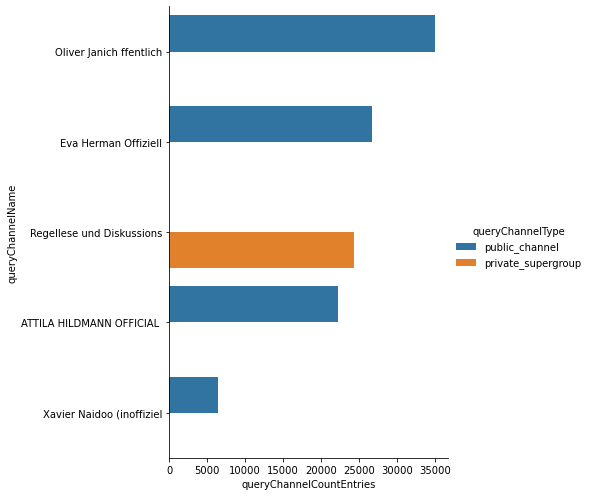

In [34]:
queryPlotter("queryChannelCountEntries")

In [35]:
#queryPlotter("queryChannelPercentRawText")

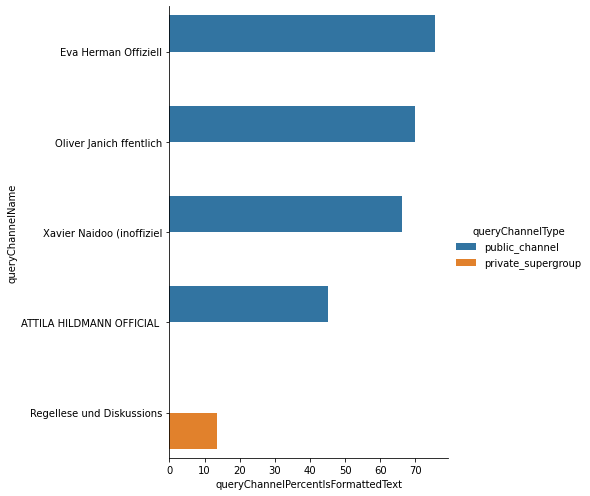

In [36]:
queryPlotter("queryChannelPercentIsFormattedText")

In [37]:
#queryPlotter("queryChannelPercentValidText") 

In [38]:
#queryPlotter("queryChannelPercentPhoto")

In [39]:
#queryPlotter("queryChannelPercentFile")

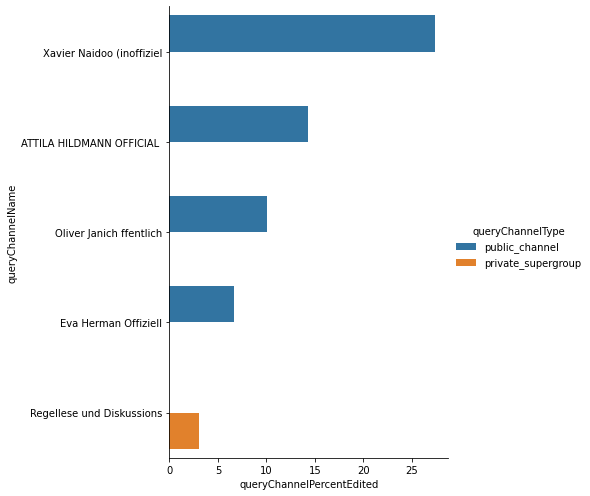

In [40]:
queryPlotter("queryChannelPercentEdited")

## Get valid text

In [41]:
def normalizedValidTextSize(df):
    df = df.copy()
    # https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame
    # keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.
    return df[np.abs(df.processedValidTextSize-df.processedValidTextSize.mean()) <= (3*df.processedValidTextSize.std())]

Before all filters		114832
Before normalizedValidTextSize	68704
After normalizedValidTextSize	67126


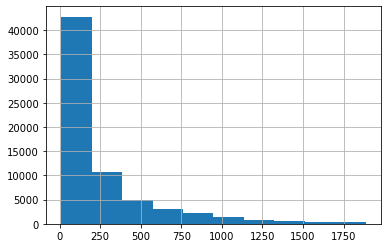

In [42]:
dfMessages = dfAllDataMessages.copy()
print("Before all filters\t\t" + str(len(dfMessages.index)))

dfMessages = dfMessages[dfMessages.processedValidTextSize > 10]
print("Before normalizedValidTextSize\t" + str(len(dfMessages.index)))

dfMessages = normalizedValidTextSize(dfMessages)
print("After normalizedValidTextSize\t" + str(len(dfMessages.index)))

_ = dfMessages.processedValidTextSize.hist()

## Extract Hashtags

In [43]:
# TODO: Extract hashtags in non formatted text

def extractImportantHashtags(filePath):
    dfMessages = dictMessages[filePath].copy()
    dfMessages = dfMessages[dfMessages.astype(str)["processedTextDataHashtags"] != "[]"]

    hashTagList = list()
    for index, row in dfMessages.iterrows():
        for hashtagItem in row["processedTextDataHashtags"]:
            hashTagList.append(hashtagItem)

    return Counter(hashTagList).most_common(20)

In [44]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-janich")

[('#StopLeftDystopia', 96),
 ('#Berlin', 40),
 ('#links', 40),
 ('#Messer', 33),
 ('#Einreise', 32),
 ('#Justiz', 32),
 ('#Kosten', 31),
 ('#Netzfund', 24),
 ('#CoronaKrise', 20),
 ('#Clan', 16),
 ('#Hamburg', 16),
 ('#COVID1984_Lüge', 16),
 ('#Orwell', 15),
 ('#Hannover', 14),
 ('#Corona', 14),
 ('#Freiheit', 13),
 ('#GreatAwakening', 13),
 ('#Psychiatrie', 12),
 ('#QAnon', 12),
 ('#NEONREVOLT', 12)]

In [45]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-27-evaherman")

[('#Abendgebet', 56),
 ('#abendgebet', 23),
 ('#StabildurchdenWandel', 22),
 ('#HermanPoppTagesnachricht', 17),
 ('#HildegardvonBingenEH', 14),
 ('#Termin', 5),
 ('#Podcast', 5),
 ('#HildegardvonBingen', 4),
 ('#RUBIKON', 4),
 ('#links', 3),
 ('#CoronaKrise', 3),
 ('#netzfund', 2),
 ('#TalkImHangar7', 2),
 ('#Coronavirus', 2),
 ('#coronavirusdeutschland', 2),
 ('#BillGates', 2),
 ('#KenFM', 2),
 ('#KritischesWeisssein', 2),
 ('#demo', 2),
 ('#Netzfund', 2)]

In [46]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-hildmann")

[('#AHMEMO', 9),
 ('#oneLove', 2),
 ('#ALUHUTSITZT', 1),
 ('#EHRENLOS', 1),
 ('#stayathome', 1),
 ('#Don', 1),
 ('#WiederWHOlungstäter', 1),
 ('#Covid1984_LÜGEN', 1),
 ('#maskeauf', 1),
 ('#BlackLivesMatter', 1),
 ('#STAYATHOME', 1),
 ('#STAYSAFE', 1),
 ('#MASKEAUF', 1),
 ('#VERTRAUTGATES', 1),
 ('#DANKEMERKEL', 1),
 ('#optinfoil', 1),
 ('#Rocker', 1),
 ('#KLARTEXT', 1),
 ('#netzfund', 1),
 ('#Netzfund', 1)]

In [47]:
extractImportantHashtags("DS-08-10-2020/ChatExport_2020-09-25-xavier")

[('#oneLove', 1335),
 ('#TEAMHEIMAT', 26),
 ('#Metropolnews', 22),
 ('#BRD', 8),
 ('#USA', 7),
 ('#netzfund', 5),
 ('#Coronavirus', 5),
 ('#Wirtschaft', 5),
 ('#Trump', 5),
 ('#Verfassung', 5),
 ('#Russland', 4),
 ('#Ankündigung', 4),
 ('#Freiheit', 4),
 ('#Weltfrieden', 4),
 ('#Corona', 4),
 ('#Berlin', 4),
 ('#Netzfund', 4),
 ('#CoronaKrise', 3),
 ('#Frieden', 3),
 ('#2WK', 3)]

## Extract Urls

In [94]:
# TODO: No Hostname if string startsWith ! "http"
# TODO: Url in non formatted text
# TODO: Add mention and other attributes
# TODO: mention in non formatted text? and other attributes

# TODO: Check if both set (from and from_id, actor, ...)
# TODO: Add cache attributes ^^ from_id -> from (map with validator)

# TODO: Duplicates in refs from text

# Text ref important for finding groups
# forwared_from important for graphs

# Return  Counter forwarded_from
def extractImportantUrls(filePath, debugPrint):
    dfMessages = dictMessages[filePath].copy()

    hostList = list()
    urList   = list()
    refList = list()
    for index, row in dfMessages.iterrows():
        if(str(row["processedTextDataURLs"]) != "[]"):
            for urlItem in row["processedTextDataURLs"]:
                urlData = urlparse(str(urlItem))

                completeHostname = urlData.hostname
                completeUrl      = urlData.geturl()

                hostList.append(str(completeHostname))
                urList.append(str(completeUrl))

                if "t.me" in str(completeHostname):
                    refList.append(str(completeUrl))
            
    forwardedFromList = list()
    if("forwarded_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():        
            forwardedFromList.append(str(row["forwarded_from"]))
            
    actorList = list()
    if("actor" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            actorList.append(str(row["actor"]))
    
    memberList = list()
    if("members" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            if(str(row["members"]) != "nan"):
                for memberItem in row["members"]:
                    memberList.append(str(memberItem))
                    
    fromList = list()
    if("from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            fromList.append(str(row["from"]))
            
    savedFromList = list()
    if("saved_from" in dfMessages.columns):
        for index, row in dfMessages.iterrows():
            savedFromList.append(str(row["saved_from"]))
        
    if(debugPrint):
        print("########################################")
        print("###### Top 20 Hosts ####################")
        print("########################################")
        print ("\n".join(map(str, Counter(hostList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 URLs #####################")
        print("########################################")
        print ("\n".join(map(str, Counter(urList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs from text ###########")
        print("########################################")
        print ("\n".join(map(str, Counter(refList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (forwarded_from) ####")
        print("########################################")
        print ("\n".join(map(str, Counter(forwardedFromList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (actor) #############")
        print("########################################")
        print ("\n".join(map(str, Counter(actorList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (members) ###########")
        print("########################################")
        print ("\n".join(map(str, Counter(memberList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (from) ##############")
        print("########################################")
        print ("\n".join(map(str, Counter(fromList).most_common(20))))
        print()

        print("########################################")
        print("###### Top 20 Refs (saved_from) ########")
        print("########################################")
        print ("\n".join(map(str, Counter(savedFromList).most_common(20))))
        print()
    
    return Counter(forwardedFromList)

In [95]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-janich", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('www.youtube.com', 2320)
('www.journalistenwatch.com', 1585)
('youtu.be', 1558)
('twitter.com', 1529)
('www.bild.de', 1004)
('www.welt.de', 952)
('www.focus.de', 922)
('t.me', 857)
('t.co', 809)
('www.epochtimes.de', 765)
('19vierundachtzig.com', 516)
('None', 416)
('focus.de', 410)
('www.n-tv.de', 387)
('jungefreiheit.de', 385)
('www.spiegel.de', 383)
('deutsch.rt.com', 266)
('www.faz.net', 253)
('www.tagesschau.de', 246)
('www.tichyseinblick.de', 219)

########################################
###### Top 20 URLs #####################
########################################
('https://t.me/Corona_Fakten/242', 59)
('https://t.me/Corona_Fakten', 41)
('http://www.expresszeitung.com/?atid=58', 39)
('https://t.me/coronainformationskanal', 35)
('Bild.de', 30)
('https://shop.expresszeitung.com/shop/shop/alle-ausgaben/ausgabe_33.html?atid=58', 24)
('t.me/Wirsindvielmehr',

In [96]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-27-evaherman", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('www.youtube.com', 2123)
('www.welt.de', 1660)
('www.kopp-verlag.de', 1187)
('www.epochtimes.de', 1164)
('www.focus.de', 987)
('www.tichyseinblick.de', 894)
('www.journalistenwatch.com', 874)
('de.sputniknews.com', 789)
('www.faz.net', 784)
('deutsch.rt.com', 702)
('jungefreiheit.de', 575)
('www.spiegel.de', 517)
('www.bild.de', 474)
('www.achgut.com', 449)
('c.kopp-verlag.de', 370)
('www.anti-spiegel.ru', 302)
('youtu.be', 298)
('www.rubikon.news', 259)
('twitter.com', 213)
('www.n-tv.de', 203)

########################################
###### Top 20 URLs #####################
########################################
('https://amzn.to/2VR6Evg', 65)
('https://www.kopp-verlag.de/Im-Lichte-der-Wahrheit.htm?websale8=kopp-verlag&pi=B4588822&ci=%24_AddOn_%24&&6=8485245', 55)
('https://www.kopp-verlag.de/a/corona-fehlalarm--3?d=1&&6=8991273', 42)
('https://c.kopp-verlag.

In [97]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-hildmann", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('youtu.be', 1413)
('www.youtube.com', 380)
('t.me', 355)
('www.bitchute.com', 174)
('None', 142)
('bit.ly', 135)
('www.spiegel.de', 120)
('www.welt.de', 114)
('amzn.to', 104)
('de.m.wikipedia.org', 76)
('www.instagram.com', 72)
('www.n-tv.de', 66)
('www.t-online.de', 54)
('www.tagesschau.de', 52)
('de.wikipedia.org', 51)
('twitter.com', 46)
('www.zeit.de', 46)
('www.rnd.de', 42)
('www.bild.de', 38)
('www.facebook.com', 36)

########################################
###### Top 20 URLs #####################
########################################
('https://bit.ly/37OCsH5', 93)
('https://www.bitchute.com/video/5izjzGo5AyBw/', 42)
('https://t.me/gerechtigkeitfuersvaterland', 26)
('https://youtu.be/o_cDlU86u48', 23)
('https://t.me/DEMOKRATENCHAT', 21)
('https://t.me/ChatDerFreiheit', 20)
('www.attilahildmann.de/alles?pc=SAMURAIPARTEI', 19)
('https://id4d.worldbank.org/

In [98]:
_ = extractImportantUrls("DS-08-10-2020/ChatExport_2020-09-25-xavier", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('youtu.be', 1047)
('t.me', 321)
('www.youtube.com', 173)
('None', 150)
('twitter.com', 124)
('music.youtube.com', 45)
('www.facebook.com', 41)
('www.bild.de', 35)
('www.welt.de', 32)
('www.journalistenwatch.com', 22)
('www.metropolnews.info', 22)
('www.focus.de', 20)
('t.co', 19)
('open.spotify.com', 19)
('de.m.wikipedia.org', 17)
('www.epochtimes.de', 16)
('www.n-tv.de', 16)
('www.xaviernaidoo.de', 14)
('www.rnd.de', 13)
('www.legitim.ch', 12)

########################################
###### Top 20 URLs #####################
########################################
('t.me/fufmedia', 32)
('https://twitter.com/HGMaassen', 12)
('https://www.youtube.com/watch?v=-qlXjhbUZnA', 12)
('https://t.me/Daniel_Prinz_Offiziell', 11)
('http://t.me/QanonAustria', 10)
('www.facebook.com/QanonAustria', 10)
('https://t.me/Demotermine', 9)
('t.me/Q_D_R_A', 9)
('https://t.me/Livestrea

In [99]:
# Just for test purposes
_ = extractImportantUrls("DS-22-10-2020/ChatExport_2020-10-13-xavierChat", debugPrint = True)

########################################
###### Top 20 Hosts ####################
########################################
('t.me', 1815)
('youtu.be', 624)
('m.freemake.com', 356)
('keepvid.pro', 356)
('politaufkleber.de', 356)
('None', 136)
('www.youtube.com', 115)
('twitter.com', 82)
('www.facebook.com', 36)
('www.welt.de', 25)
('www.metropolnews.info', 21)
('www.bild.de', 20)
('www.journalistenwatch.com', 13)
('telegra.ph', 13)
('de.m.wikipedia.org', 13)
('www.focus.de', 13)
('www.epochtimes.de', 10)
('www.legitim.ch', 10)
('m.bild.de', 9)
('19vierundachtzig.com', 9)

########################################
###### Top 20 URLs #####################
########################################
('https://m.freemake.com/de/free_video_downloader/', 356)
('https://t.me/Gozilla_bot', 356)
('https://keepvid.pro/de24/', 356)
('http://t.me/WIR_sind_viel_mehr', 356)
('https://t.me/EinleitungHilfeTelegram', 356)
('https://politaufkleber.de/produkt/teamxavier-telegram-fangruppen-shirt-auswahl/', 35

## Word Clouds

In [236]:
#TODO Difference capital letters?
#TODO Context?

# Use "global" for all DataFrames
def plotChannelWordCloud(filePath, label, filterList):
    timeStart = time.time()
    
    if(filePath != "global"):
        dfMessages = dictMessages[filePath].copy()
    else:
        dfMessages = dfAllDataMessages.copy()
    
    print("[Start transform text to global text string]")
    textList = []
    for index, row in dfMessages.iterrows():
        textList.append(" " + row["processedValidText"])
        
    textString = ''.join(textList)
    
    germanStopWordsList = nltk.corpus.stopwords.words('german')
    germanStopWordsList.append("http")
    germanStopWordsList.append("https")
    germanStopWordsList.append("ja") #TODO: split to local - maybe?
    germanStopWordsList.append("nein")
    germanStopWordsList.append("mehr")
    germanStopWordsList.append("mal")
    germanStopWordsList.append("schon")
    germanStopWordsList.append("immer")
    germanStopWordsList.append("wurde")
    germanStopWordsList.append("wurden")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("viel")
    germanStopWordsList.append("viele")
    germanStopWordsList.append("wegen")
    germanStopWordsList.append("müssen")
    germanStopWordsList.append("geht")
    germanStopWordsList.append("gibt")
    germanStopWordsList.append("wer")
    germanStopWordsList.append("wie")
    germanStopWordsList.append("was")
    germanStopWordsList.append("macht")
    germanStopWordsList.append("machen")
    germanStopWordsList.append("machte")
    germanStopWordsList.append("kommen")
    germanStopWordsList.append("kommt")
    germanStopWordsList.append("glaube")
    germanStopWordsList.append("glaubst")
    germanStopWordsList.append("tun")
    germanStopWordsList.append("wäre")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hast")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("habt")
    germanStopWordsList.append("statt")
    germanStopWordsList.append("genau")
    germanStopWordsList.append("sagen")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sagten")
    germanStopWordsList.append("bitte")
    germanStopWordsList.append("bitten")
    germanStopWordsList.append("danke")
    germanStopWordsList.append("dank")
    germanStopWordsList.append("sollen")
    germanStopWordsList.append("soll")
    germanStopWordsList.append("sollte")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("zeigen")
    germanStopWordsList.append("zeigt")
    germanStopWordsList.append("sei")
    germanStopWordsList.append("sein")
    germanStopWordsList.append("seid")
    germanStopWordsList.append("seit")
    germanStopWordsList.append("laut")
    germanStopWordsList.append("lauten")
    germanStopWordsList.append("sehen")
    germanStopWordsList.append("seht")
    germanStopWordsList.append("haben")
    germanStopWordsList.append("hat")
    germanStopWordsList.append("hätten")
    germanStopWordsList.append("sagte")
    germanStopWordsList.append("sag")
    germanStopWordsList.append("sagt")
    germanStopWordsList.append("ab")
    germanStopWordsList.append("bei")
    germanStopWordsList.append("beim")
    germanStopWordsList.append("denen")
    germanStopWordsList.append("gab")
    germanStopWordsList.append("ab")
    
    for fItem in filterList:
        germanStopWordsList.append(fItem)
    
    print("[Start generate wordCloud]")
    wordcloud = WordCloud(
                background_color="black",
                width=1920,
                height=1080,
                stopwords=germanStopWordsList
            ).generate(textString)
    wordcloud.to_file(dir_var_output + "wordcloud-" + label + ".png")
    
    print("Top 20 occ:\n" + str(pd.Series(wordcloud.words_).head(20)))
    
    print("[Start generate figure]")
    plt.figure(figsize=(14, 14))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

### Public channels

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland    1.000000
Menschen       0.777668
Video          0.774704
Polizei        0.609190
bereit         0.540020
Berlin         0.465909
Corona         0.420455
Prozent        0.414032
neue           0.398715
AfD            0.389822
dabei          0.381423
Fall           0.371047
Welt           0.368577
and            0.368577
Kinder         0.364625
a              0.362154
heute          0.361660
deutschen      0.354249
Trump          0.350296
seien          0.347332
dtype: float64
[Start generate figure]


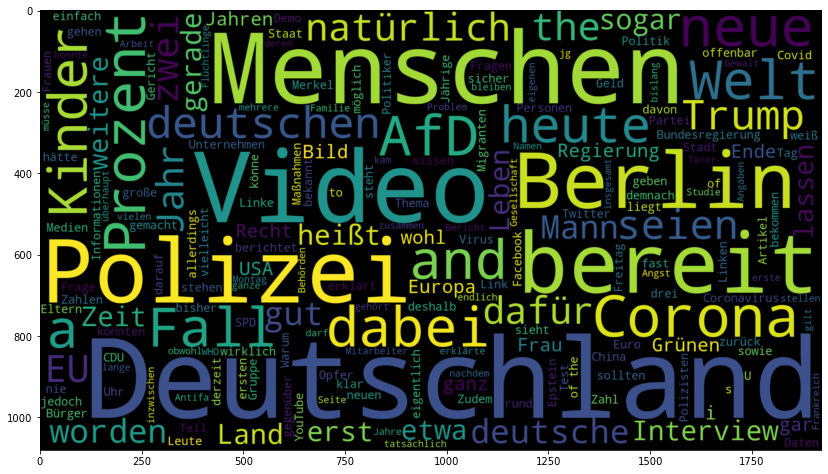

[Finished]
12.153s


In [238]:
# Oliver Janich öffentlich (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-janich",
    "pc-janich",
    []
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Menschen       1.000000
Deutschland    0.669903
heute          0.593620
Corona         0.540915
Video          0.450069
Welt           0.424411
bereit         0.408460
Coronavirus    0.384189
Kinder         0.383495
Zeit           0.382108
Liebe Eva      0.371706
China          0.360610
Virus          0.348128
Leben          0.321775
Zuschrift      0.319001
Berlin         0.316921
USA            0.306519
Polizei        0.291956
Eva Herman     0.283634
gerade         0.278086
dtype: float64
[Start generate figure]


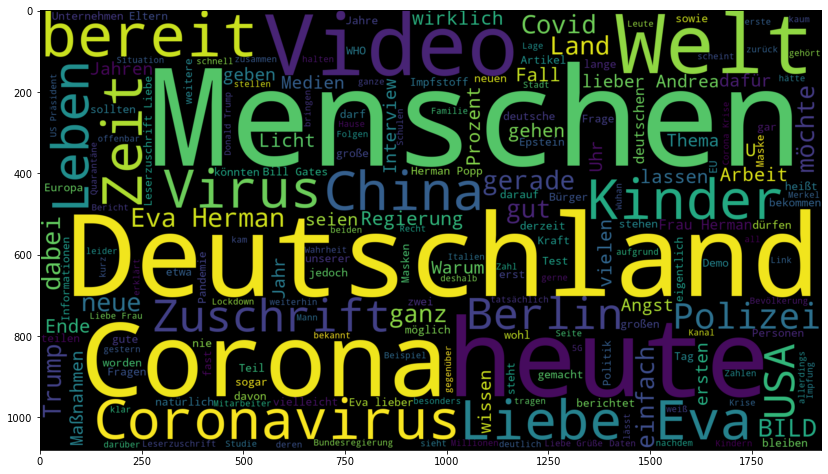

[Finished]
12.320s


In [56]:
# Eva Herman Offiziell (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-27-evaherman",
    "pc-evaHerman",
    []
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Deutschland                  1.000000
Corona                       0.751402
Gate                         0.626168
Merkel                       0.593458
Menschen                     0.576636
WOLF ATTILAHILDMANN          0.486916
China                        0.484112
ATTILAHILDMANN CHAT          0.457009
CHAT BEITRETEN               0.453271
BEITRETEN ChatDerFreiheit    0.449533
heute                        0.438318
FOLG                         0.390654
Video                        0.373832
Freiheit                     0.373832
deutschen                    0.363551
einfach                      0.362617
NWO                          0.341121
Welt                         0.302804
ATTILA HILDMANN              0.300935
Zeit                         0.270093
dtype: float64
[Start generate figure]


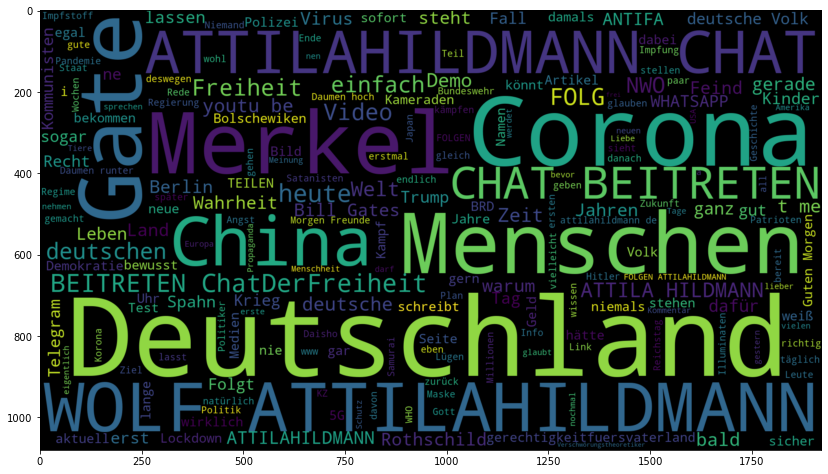

[Finished]
12.440s


In [57]:
# ATTILA HILDMANN OFFICIAL (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-hildmann",
    "pc-hildmann",
    ["ATTILAHILDMANN CHAT"]
)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
oneLove          1.000000
Menschen         0.256331
Video            0.153799
Deutschland      0.151328
Corona           0.142063
Kinder           0.126004
Wahrheit         0.119827
Berlin           0.114886
Kanäle           0.109944
Liebe            0.096973
Warum            0.096973
einfach          0.092032
heute            0.089561
Zeit             0.088326
Polizei          0.088326
Demo             0.088326
bereit           0.084620
Welt             0.080914
lassen           0.075355
Xavier Naidoo    0.075355
dtype: float64
[Start generate figure]


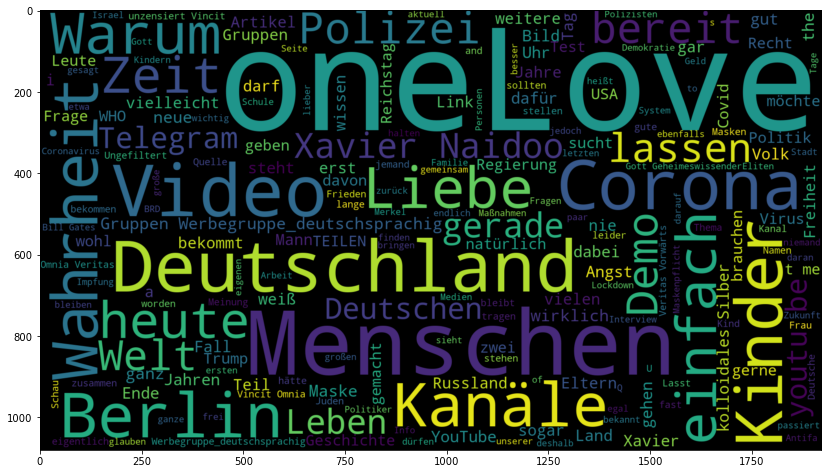

[Finished]
10.718s


In [58]:
# Xavier Naidoo (public_channel)
plotChannelWordCloud(
    "DS-08-10-2020/ChatExport_2020-09-25-xavier",
    "pc-xavier",
    ["xavier_naidoo", "Xavier_Naidoo", "politische_bildersprueche", "einmal_hin_alles_drin"]
)

In [59]:
# Gerechtigkeit für das Vaterland (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-gerechtigkeitVaterland",
#    "pc-GerechtigkeitfuerdasVaterland",
#    ["gerechtigkeitfuersvaterland"]
#)

In [60]:
# Corona Virus Informationen (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-cvirusinfo",
#    "pc-cVirusInfo",
#    [])

In [61]:
# Liberté (public_channel)
#plotChannelWordCloud(
#    "DS-08-10-2020/ChatExport_2020-09-26-liberte",
#    "pc-liberte",
#    []
#)

[Start transform text to global text string]
[Start generate wordCloud]
Top 20 occ:
Menschen                 1.000000
Deutschland              0.865236
Video                    0.617918
heute                    0.474308
Corona                   0.454169
Welt                     0.403350
einfach                  0.400339
Kinder                   0.399021
bereit                   0.395445
Berlin                   0.389987
Polizei                  0.386599
oneLove Xavier_Naidoo    0.377188
Recht                    0.356108
Gruppe                   0.350649
Leben                    0.311688
gut                      0.307736
Warum                    0.305101
dabei                    0.303783
gerade                   0.301713
natürlich                0.292302
dtype: float64
[Start generate figure]


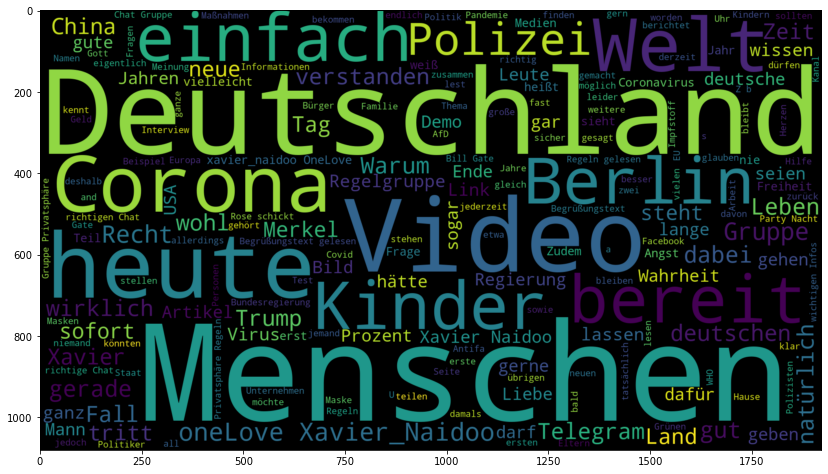

[Finished]
33.768s


In [62]:
# Just for test purposes
plotChannelWordCloud(
    "global",
    "global",
    []
)

## Graphs

### !!!!!!!!!!!!!!!! Quick Filter !!!!!!!!!!!!!!!!!!!!

In [254]:
# Take only samples
#dfFilter = pd.DataFrame()

#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Xavier")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Janich")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Eva")])
#dfFilter = dfFilter.append(dfInputFiles[dfInputFiles.inputName.str.contains("Janich") == False])

#dfInputFiles = dfFilter

In [255]:
# TODO Nan?
# TODO https://networkx.org/documentation/stable/reference/drawing.html#module-networkx.drawing.layout
# (try different layouts e.g. circular_layout)

def addNodeSize(label, newSize, targetDict):
    
    if(label in targetDict):
        oldSize = targetDict[label]
        if(newSize > oldSize):
            targetDict[label] = newSize
    else:
        targetDict[label] = newSize
        
dicNodeSize = dict()

def printGraph():
    
    print("[Start generating graph...]")
    timeStart = time.time()
    
    # ##################################
    # ###### Generate Graph ############
    # ##################################
    G_weighted = nx.DiGraph()
    
    # ##################################
    # ###### Add Edges ############
    # ##################################
    for fP in filterInputPaths:
        
        groupName = queryChannelName(fP)
        groupSize = queryChannelCountEntries(fP)

        mostCounter = extractImportantUrls(fP, debugPrint=False)
        mostCounter = mostCounter.most_common(20)

        #Debug Print
        #print("Process now >>" + groupName + "<< (" + str(groupSize) + ") -")

        addNodeSize(groupName, groupSize, dicNodeSize)
        
        for gRN, gRS in mostCounter:
            
            groupRefName    = str(gRN)
            groupRefSize    = gRS

            if(groupRefName != "nan" and groupRefSize > 10):
                
                groupRefName = groupRefName.encode('ascii', 'ignore')
                groupRefName = groupRefName.decode('ascii')
                groupRefName = groupRefName[:25]
                
                #Debug Print
                #print("- Add >>" + groupRefName + "<< (" + str(groupRefSize) + ")")
            
                addNodeSize(groupRefName, groupRefSize, dicNodeSize)
                G_weighted.add_edge(groupName, groupRefName, weight=groupRefSize / 100)
        
    # ##################################
    # ###### Add different node sizes ##
    # ##################################
    for aNode in dicNodeSize:
        
        nodeName = str(aNode)
        nodeSize = dicNodeSize[aNode]
        
        #Debug Print
        #print("- Add Node >>" + nodeName + "<< (" + str(nodeSize) + ")")
        
        G_weighted.add_node(nodeName, weight=nodeSize / 10)
            
    # ##################################
    # ###### Draw ######################
    # ##################################
    plt.figure(figsize=(16,9))
        
    pos = nx.spring_layout(G_weighted)
        
    nx.draw(G_weighted,
        pos,
        #node_color='lightgreen',
        with_labels=True,
        #edge_color=colors, 
        width=list(nx.get_edge_attributes(G_weighted, "weight").values()),
        #edge_labels=edge_labels,
        node_size=list(nx.get_node_attributes(G_weighted,'weight').values()),
        arrowsize=10,
    )
        
    edge_labels = nx.get_edge_attributes(G_weighted, "weight")

    _ = nx.draw_networkx_edge_labels(G_weighted, pos, edge_labels=edge_labels)

    plt.savefig(dir_var_output + "graph.png")
    plt.show()
    
    timeEnd = time.time()
    print("[Finished]")
    print('{:5.3f}s'.format(timeEnd-timeStart))

[Start generating graph...]


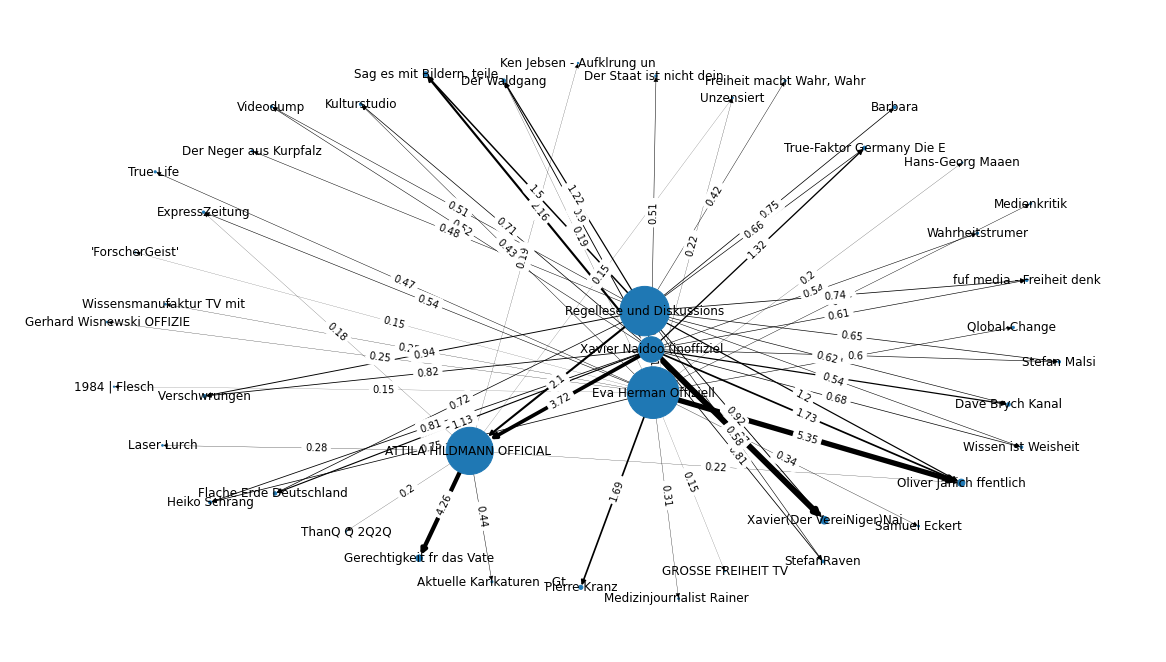

[Finished]
22.380s


In [256]:
_ = printGraph()

In [174]:
#G_weighted = nx.DiGraph()

#G_weighted.add_edge('A', 'B', weight=8)
#G_weighted.add_edge('A', 'C', weight=2)
#G_weighted.add_edge('A', 'D', weight=5)

#G_weighted.add_node('A', weight=500)
#G_weighted.add_node('C', weight=500)
#G_weighted.add_node('D', weight=500)
#G_weighted.add_node('B', weight=500)

In [89]:
#from ipywidgets import interact
#import ipywidgets as widgets

In [69]:
#interact(plot_random_graph, n=(2,30), m=(1,10), k=(1,10), p=(0.0, 1.0, 0.001),
#         generator={
#             'lobster': random_lobster,
#             'power law': powerlaw_cluster,
#             'Newman-Watts-Strogatz': newman_watts_strogatz,
#             u'Erdős-Rényi': erdos_renyi,
#         });

## Concordance

In [63]:
#tbd